In [1]:
# COGNITIVE COMPUTING ML PROJECT
# Title - House Price Prediction Model
# Group Members - Abhishek Panchal       102317167
#                 Kaushik Gupta          102317265

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import shap

In [3]:
# Load dataset
df = pd.read_csv(r"C:\Users\ASUS\Downloads\house-prices-advanced-regression-techniques\train.csv") 

In [4]:
# Define base features and target variable
selected_features = ['OverallQual', 'GrLivArea', 'BsmtUnfSF', 'GarageCars','TotalSF',
                     'Age', 'RemodAge', 'LotFrontage', 'Neighborhood']

target = 'SalePrice'

In [5]:
# Creating derived features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Age'] = df['YrSold'] - df['YearBuilt']
df['RemodAge'] = df['YrSold'] - df['YearRemodAdd'] 

In [6]:
# Neighborhood Price Trends
df['Neighborhood_MedianPrice'] = df.groupby('Neighborhood')['SalePrice'].transform('median')

# Clustering Neighborhoods
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
df['Neighborhood_Cluster'] = kmeans.fit_predict(df[['Neighborhood_MedianPrice']])

In [7]:
# Outlier Removal using Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outliers = lof.fit_predict(df[['GrLivArea','TotalSF']])    

# Keep only inliers (LOF labels inliers as 1 and outliers as -1)
df = df[outliers == 1]

In [8]:
# Advanced Feature Engineering
# Interaction Features
df['Qual_LivArea'] = df['OverallQual'] * df['GrLivArea']
df['Garage_Qual'] = df['GarageCars'] * df['OverallQual']

# Polynomial Features
df['TotalSF_Sq'] = df['TotalSF'] ** 2
df['Age_Sq'] = df['Age'] ** 2

In [9]:
# Selecting relevant columns
df_selected = df[selected_features + ['Qual_LivArea', 'Garage_Qual','TotalSF_Sq',
                                       'Age_Sq','Neighborhood_MedianPrice', 
                                      'Neighborhood_Cluster', target]].copy()

In [10]:
# Handling missing values
imputer = SimpleImputer(strategy='median')
df_selected['LotFrontage'] = imputer.fit_transform(df_selected[['LotFrontage']])

# Drop the original 'Neighborhood' column if it exists
if 'Neighborhood' in df_selected.columns:
    df_selected.drop(columns=['Neighborhood'], inplace=True)

In [11]:
# Splitting data into training, validation, and test sets
X = df_selected.drop(columns=[target])
y = df_selected[target]

# First split: Train + Validation and Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)

# Second split: Validation and Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Define hyperparameter grids
rf_params = {
    'n_estimators': [100, 200],         
    'max_depth': [6, 8],           
    'min_samples_split': [12, 15],    
    'min_samples_leaf': [4, 6, 8]       
}

dt_params = {
    'max_depth': [8, 10, 12, 15],            # Experimenting with greater depth
    'min_samples_split': [6, 8, 10],         # Smaller splits for finer granularity
    'min_samples_leaf': [3, 5, 7]            # Smaller leaf size for more patterns
}

xgb_params = {
    'n_estimators': [500, 1000, 1500],        # Keep iterations sufficient for convergence
    'learning_rate': [0.005, 0.01, 0.015],   # Focus on smaller step sizes for smooth learning
    'max_depth': [4, 5, 6],                  # Slightly reduced depth to control complexity
    'subsample': [0.7, 0.8, 0.9],            # Larger subsamples for better generalization
    'colsample_bytree': [0.6, 0.7, 0.8],     # Explore optimal feature subset sizes
    'min_child_weight': [6, 8, 10],          # Increase minimum weight to reduce bias on small data
    'gamma': [3, 4, 5],                      # Slightly tighter gamma values for regularization
    'reg_lambda': [0.8, 1.0, 1.2],           # L2 regularization to handle large coefficients
    'reg_alpha': [0.5, 1.0, 1.5]             # L1 regularization to shrink less important features
}



In [13]:
# Hyperparameter tuning
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                               rf_params, n_iter=8, cv=5, scoring='neg_mean_squared_error',
                               random_state=42, n_jobs=-1)

dt_random = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), 
                               dt_params, n_iter=8, cv=5, scoring='neg_mean_squared_error', 
                               random_state=42, n_jobs=-1)

xgb_random = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                                xgb_params, n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                random_state=42, n_jobs=-1)

In [14]:
# Train models
rf_random.fit(X_train_scaled, y_train)
dt_random.fit(X_train_scaled, y_train)
xgb_random.fit(X_train_scaled, y_train)

# Get best models
best_rf = rf_random.best_estimator_
best_dt = dt_random.best_estimator_
best_xgb = xgb_random.best_estimator_

# Predictions
rf_preds = best_rf.predict(X_test_scaled)
dt_preds = best_dt.predict(X_test_scaled)
xgb_preds = best_xgb.predict(X_test_scaled)


In [15]:
# Evaluate models
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
dt_rmse = mean_squared_error(y_test, dt_preds, squared=False)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)

# Calculate R-squared
rf_r2 = best_rf.score(X_test_scaled, y_test)
dt_r2 = best_dt.score(X_test_scaled, y_test)
xgb_r2 = best_xgb.score(X_test_scaled, y_test)

# Calculate Mean Absolute Error (MAE) for each model
rf_mae = mean_absolute_error(y_test, rf_preds)
dt_mae = mean_absolute_error(y_test, dt_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)

In [16]:
# Print results
print("\n===== MODEL PERFORMANCE =====")
print(f"Random Forest RMSE: ${rf_rmse:.2f}, R^2: {rf_r2:.4f}, MAE: ${rf_mae:.2f}")
print(f"Decision Tree RMSE: ${dt_rmse:.2f}, R^2: {dt_r2:.4f}, MAE: ${dt_mae:.2f}")
print(f"XGBoost RMSE: ${xgb_rmse:.2f}, R^2: {xgb_r2:.4f}, MAE: ${xgb_mae:.2f}")


===== MODEL PERFORMANCE =====
Random Forest RMSE: $21157.06, R^2: 0.9247, MAE: $14403.68
Decision Tree RMSE: $29493.32, R^2: 0.8536, MAE: $19921.67
XGBoost RMSE: $20181.83, R^2: 0.9315, MAE: $13909.59


In [19]:
# SHAP ANALYSIS AND VISUALISATION

# ========== 1. STYLING AND SETUP ==========
# Set consistent styling for all visualizations
plt.style.use('seaborn-v0_8-whitegrid')  # Clean style with grid lines
sns.set_palette("viridis")  # Modern, colorblind-friendly palette
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

In [20]:
# ========== 2. MODEL COMPARISON SETUP ==========
# Collect all predictions
actual_prices = y_test
all_predictions = {
    "Random Forest": rf_preds,
    "Decision Tree": dt_preds,
    "XGBoost": xgb_preds
}

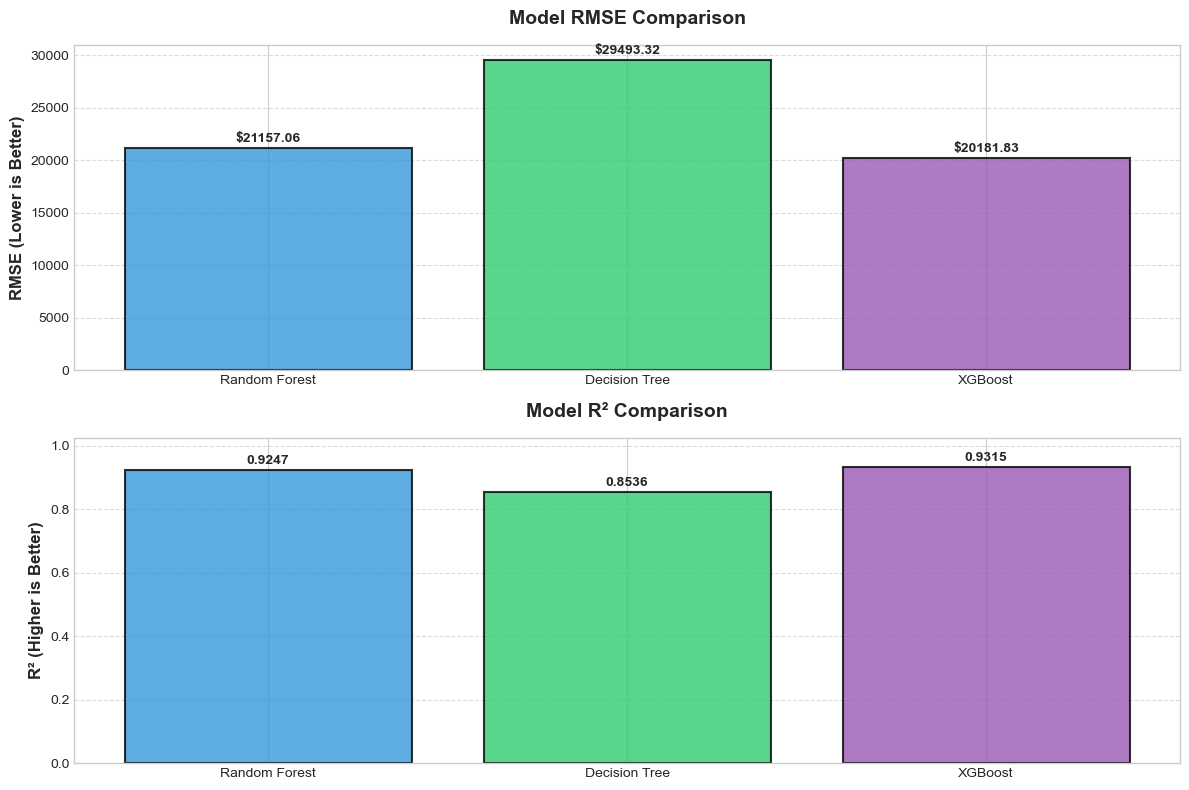


===== MODEL ANALYSIS SUMMARY =====
Best model: XGBoost


In [21]:
# ========== 3. MODEL PERFORMANCE BAR CHARTS ==========
plt.figure(figsize=(12, 8))
model_names = ["Random Forest", "Decision Tree", "XGBoost"]
model_colors = ['#3498db', '#2ecc71', '#9b59b6']  # Distinct colors for each model

# RMSE Comparison
plt.subplot(2, 1, 1)
rmse_values = [rf_rmse, dt_rmse, xgb_rmse]
bars = plt.bar(model_names, rmse_values, color=model_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
plt.ylabel("RMSE (Lower is Better)", fontweight='bold')
plt.title("Model RMSE Comparison", fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(rmse_values)*0.01),
             f'${height:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# R² Comparison
plt.subplot(2, 1, 2)
r2_values = [rf_r2, dt_r2, xgb_r2]
bars = plt.bar(model_names, r2_values, color=model_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
plt.ylabel("R² (Higher is Better)", fontweight='bold')
plt.title("Model R² Comparison", fontweight='bold', pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(r2_values) * 1.1)  # Give some space above the highest bar

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (max(r2_values)*0.01),
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')
             
plt.tight_layout()
plt.show()

print("\n===== MODEL ANALYSIS SUMMARY =====")
print(f"Best model: {'XGBoost' if xgb_rmse < min(rf_rmse, dt_rmse) else 'Random Forest' if rf_rmse < dt_rmse else 'Decision Tree'}")

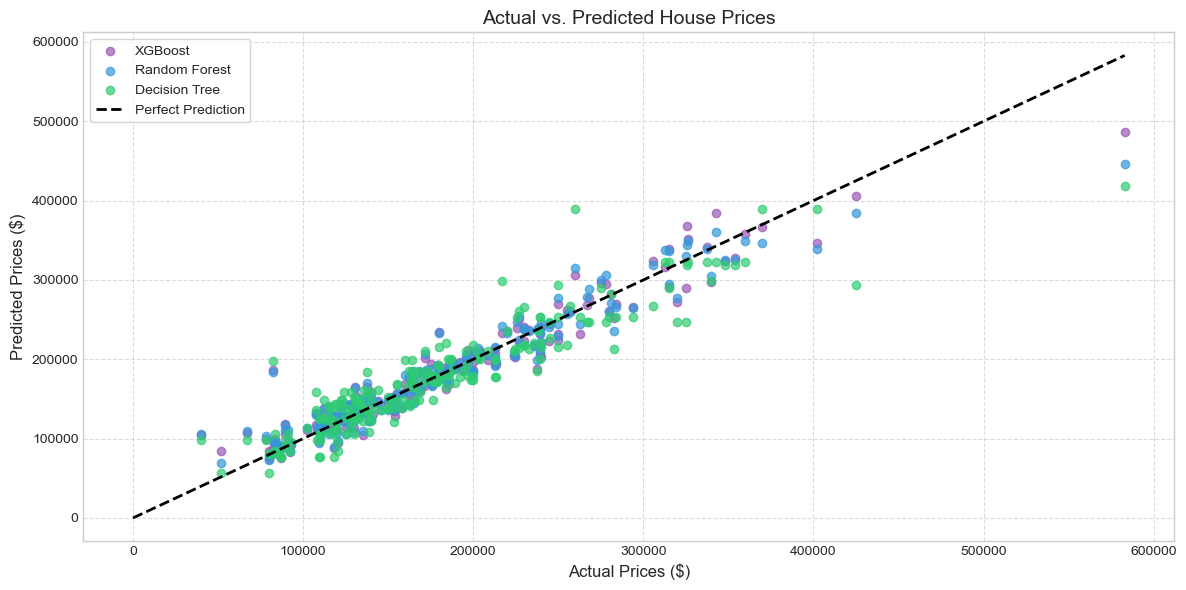

In [22]:
# ========== 4. ACTUAL VS PREDICTED COMPARISON ==========
plt.figure(figsize=(12, 6))
plt.scatter(actual_prices, xgb_preds, alpha=0.7, label="XGBoost", color="#9b59b6")
plt.scatter(actual_prices, rf_preds, alpha=0.7, label="Random Forest", color="#3498db")
plt.scatter(actual_prices, dt_preds, alpha=0.7, label="Decision Tree", color="#2ecc71")
plt.plot([0, max(actual_prices)], [0, max(actual_prices)], 'k--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Prices ($)")
plt.ylabel("Predicted Prices ($)")
plt.legend(loc='upper left', frameon=True)
plt.title("Actual vs. Predicted House Prices")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# ========== 5. MODEL SELECTION ==========
# Choose the best model based on performance metrics
best_model = best_xgb  
best_preds = xgb_preds
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [24]:
# ========== 6. SHAP EXPLAINER CREATION ==========
# Create a SHAP explainer based on your best model
if isinstance(best_model, XGBRegressor):
    explainer = shap.Explainer(best_model)
    shap_values = explainer(X_test_df)
else:  # For Random Forest or Decision Tree
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_df)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19080\3573994106.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


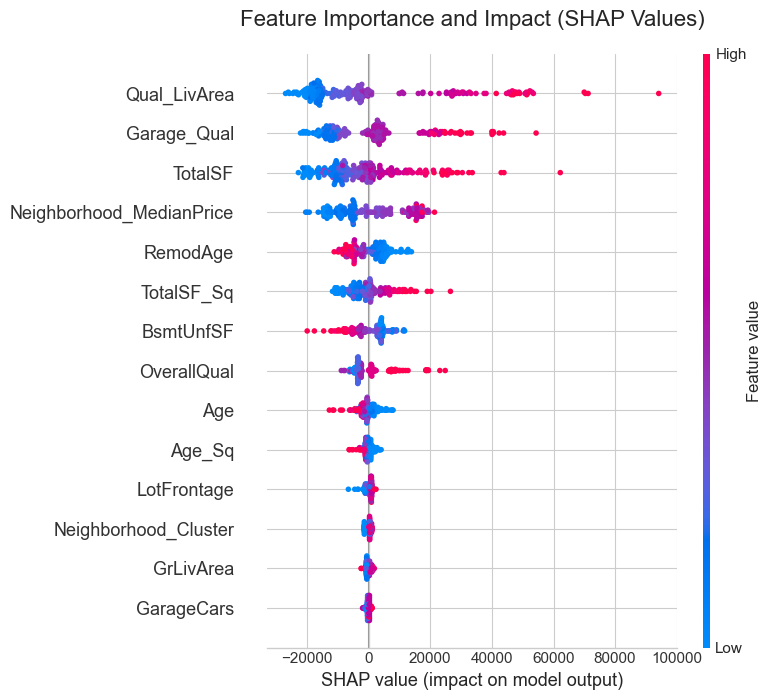

In [25]:
# ========== 7. SHAP SUMMARY PLOT ==========
# Shows feature importance and impact direction
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_df, show=False)
plt.title("Feature Importance and Impact (SHAP Values)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Top 3 most important features: TotalSF, Garage_Qual, Qual_LivArea


C:\Users\ASUS\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\ASUS\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


<Figure size 1200x1000 with 0 Axes>

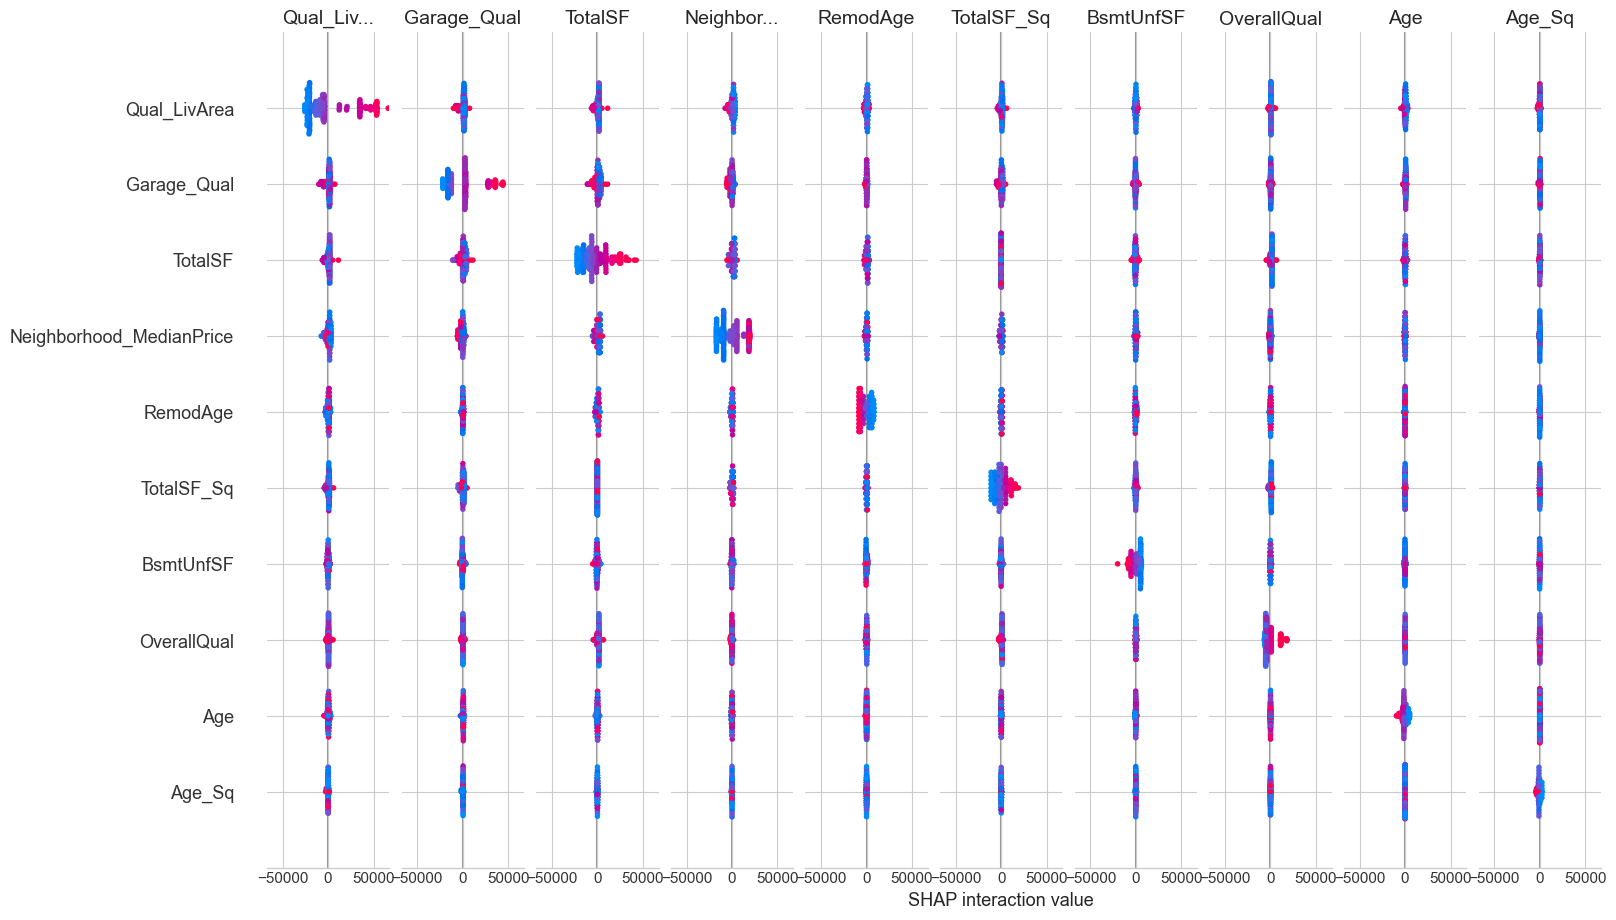

<Figure size 640x480 with 0 Axes>

In [26]:
# ========== 8. FEATURE IMPORTANCE ==========
# Get the top features by importance
if isinstance(best_model, XGBRegressor):
    feature_importance = np.abs(shap_values.values).mean(0)
    top_indices = np.argsort(feature_importance)[-3:]
    top_features = X_test_df.columns[top_indices]
else:
    feature_importance = np.abs(shap_values).mean(0)
    top_indices = np.argsort(feature_importance)[-3:]
    top_features = X_test_df.columns[top_indices]
    
print(f"Top 3 most important features: {', '.join(top_features)}")

# Add SHAP interaction analysis
interaction_values = explainer.shap_interaction_values(X_test_df)
plt.figure(figsize=(12, 10))
shap.summary_plot(interaction_values, X_test_df, max_display=10)
plt.tight_layout()
plt.show()

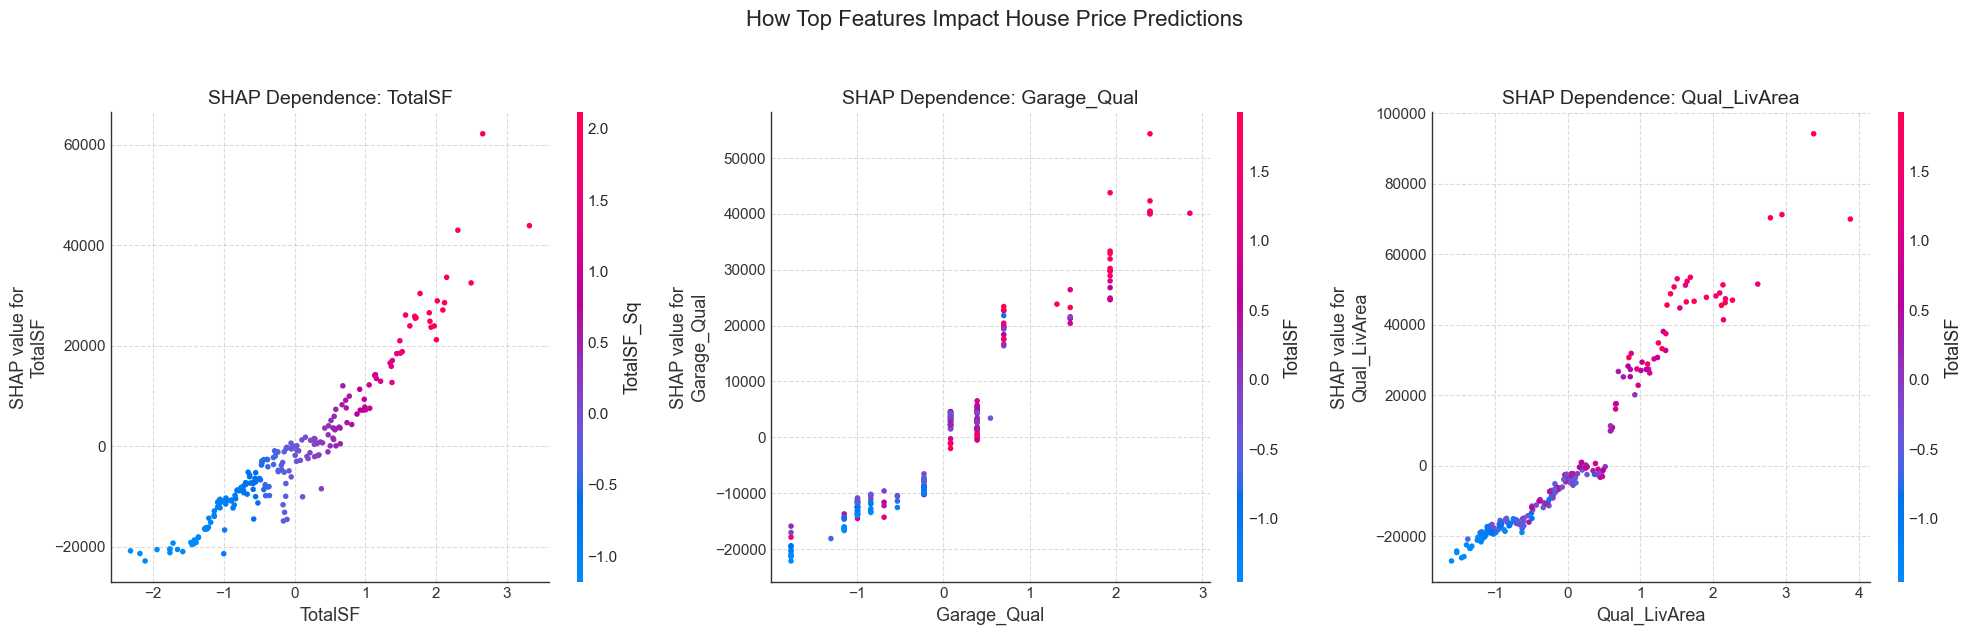

In [27]:
# ========== 9. SHAP DEPENDENCY PLOTS ==========
# Create dependency plots for top features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, feature in enumerate(top_features):
    if isinstance(best_model, XGBRegressor):
        shap.dependence_plot(feature, shap_values.values, X_test_df, ax=axes[i], show=False)
    else:
        shap.dependence_plot(list(X_test_df.columns).index(feature), shap_values, X_test_df, ax=axes[i], show=False)
    axes[i].set_title(f"SHAP Dependence: {feature}", fontsize=14)
    axes[i].grid(True, linestyle='--', alpha=0.7)
fig.suptitle("How Top Features Impact House Price Predictions", fontsize=16, y=1.05)
fig.tight_layout()
plt.show()

In [28]:
# ========== 10. ERROR ANALYSIS SETUP ==========
# Calculate errors for the best model
errors = y_test - best_preds
abs_errors = np.abs(errors)
perc_errors = (abs_errors / y_test) * 100

# Create a dataframe for error analysis
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': best_preds,
    'Error': errors,
    'Abs_Error': abs_errors,
    'Perc_Error': perc_errors
})

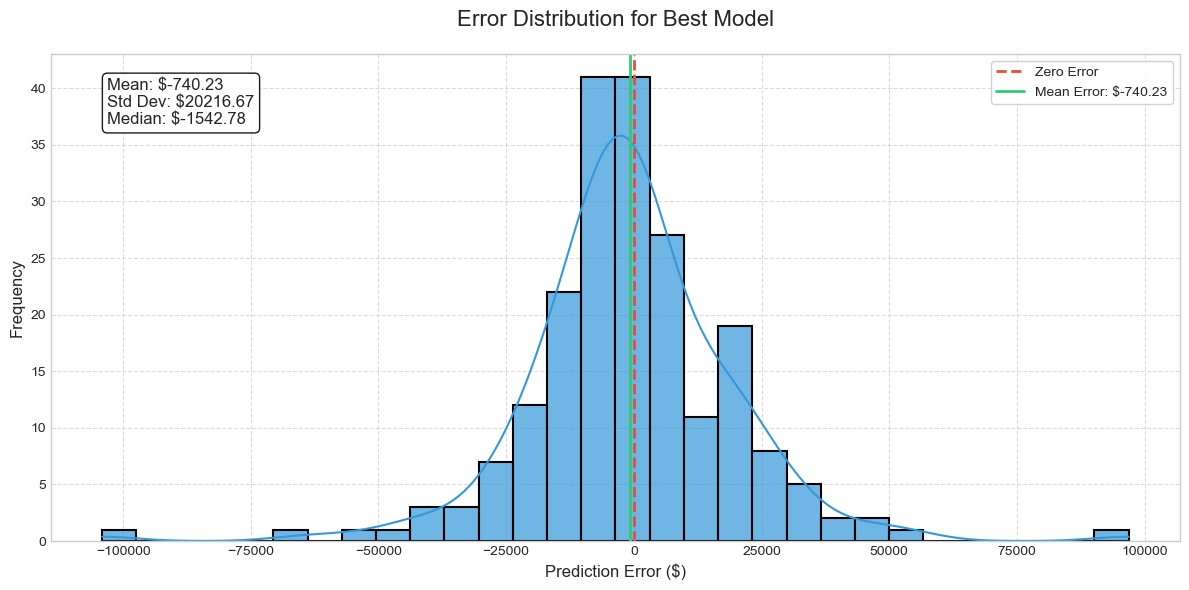


===== ERROR ANALYSIS =====
Mean absolute error: $13909.59
Mean percentage error: 9.21%
Median absolute error: $9412.58
90th percentile of absolute error: $29640.34


In [29]:
# ========== 11. ERROR DISTRIBUTION PLOT ==========
plt.figure(figsize=(12, 6))
sns.histplot(errors, bins=30, kde=True, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
plt.axvline(x=0, color='#e74c3c', linestyle='--', linewidth=2, label='Zero Error')
plt.axvline(x=errors.mean(), color='#2ecc71', linestyle='-', linewidth=2, label=f'Mean Error: ${errors.mean():.2f}')
plt.title("Error Distribution for Best Model", fontsize=16, pad=20)
plt.xlabel("Prediction Error ($)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=True, framealpha=0.9)

# Add statistical annotations
textstr = f'Mean: ${errors.mean():.2f}\nStd Dev: ${errors.std():.2f}\nMedian: ${np.median(errors):.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
plt.annotate(textstr, xy=(0.05, 0.95), xycoords='axes fraction',
            bbox=props, fontsize=12, verticalalignment='top')
plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n===== ERROR ANALYSIS =====")
print(f"Mean absolute error: ${error_df['Abs_Error'].mean():.2f}")
print(f"Mean percentage error: {error_df['Perc_Error'].mean():.2f}%")
print(f"Median absolute error: ${error_df['Abs_Error'].median():.2f}")
print(f"90th percentile of absolute error: ${error_df['Abs_Error'].quantile(0.9):.2f}")

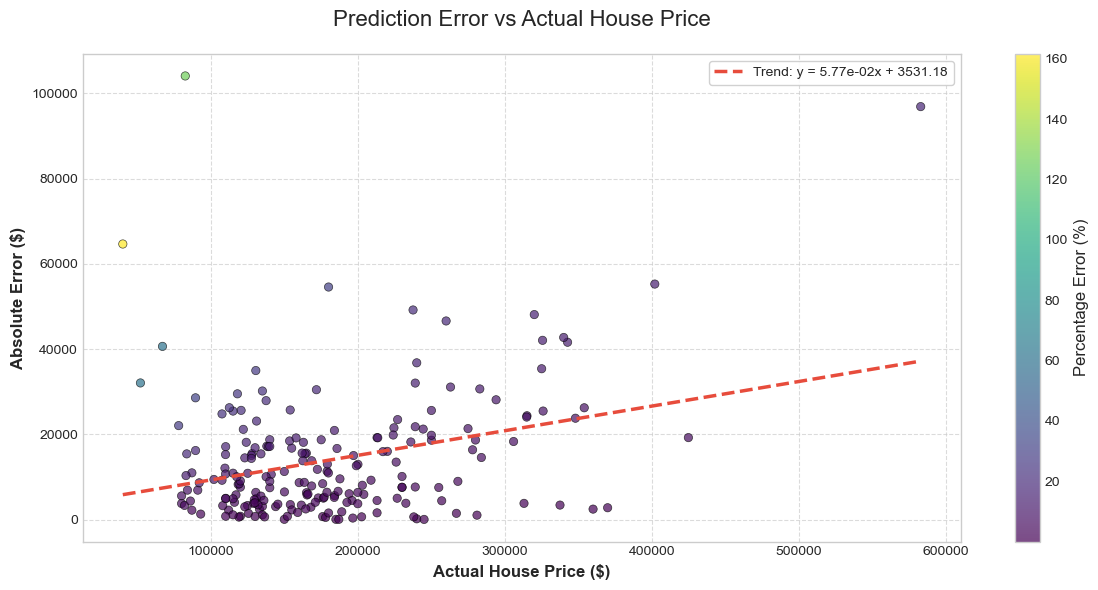

In [30]:
# ========== 12. ERROR VS ACTUAL PRICE PLOT ==========
plt.figure(figsize=(12, 6))
scatter = plt.scatter(y_test, abs_errors, alpha=0.7, c=perc_errors, cmap='viridis', 
                     edgecolor='black', linewidth=0.5)
plt.colorbar(scatter, label='Percentage Error (%)')
plt.xlabel("Actual House Price ($)", fontweight='bold')
plt.ylabel("Absolute Error ($)", fontweight='bold')
plt.title("Prediction Error vs Actual House Price", fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Add trend line with improved styling
z = np.polyfit(y_test, abs_errors, 1)
p = np.poly1d(z)
x_trend = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_trend, p(x_trend), color='#e74c3c', linestyle='--', linewidth=2.5, 
         label=f'Trend: y = {z[0]:.2e}x + {z[1]:.2f}')
plt.legend(frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()